# Data Pre-processing

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats

C:\Users\deric\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data_dir = 'data'

In [3]:
df = pd.read_csv(os.path.join(data_dir, 'vehicles_concat.csv'))

df

,price,model,condition,fuel,odometer,transmission,drive,size,type,paint_color
0,24895.0,jeep-cherokee,unspecified,gas,6973.0,automatic,4wd,unspecified,SUV,white
1,12999.0,nissan-altima,unspecified,gas,63810.0,unspecified,fwd,unspecified,sedan,unspecified
2,12799.0,hyundai-elantra,unspecified,gas,80210.0,automatic,unspecified,unspecified,sedan,silver
3,17850.0,ford-f150,unspecified,gas,76393.0,automatic,rwd,unspecified,unspecified,white
4,24150.0,dodge-challenger,unspecified,gas,74540.0,automatic,rwd,unspecified,coupe,white
...,...,...,...,...,...,...,...,...,...,...
106877,33064.0,ram-1500,unspecified,gas,42920.0,automatic,4wd,unspecified,unspecified,black
106878,27987.0,toyota-tacoma,unspecified,unspecified,44444.0,automatic,rwd,unspecified,unspecified,unspecified
106879,32663.0,chevrolet-traverse,unspecified,gas,18498.0,automatic,4wd,unspecified,SUV,silver
106880,22986.0,chevrolet-equinox,unspecified,gas,21598.0,automatic,4wd,unspecified,SUV,white


In [64]:
df = df.sample(frac=1)

In [65]:
def one_hot_encode(df, feature):
    dummies = pd.get_dummies(df[feature], prefix=feature)
    
    df = pd.concat([df, dummies], axis=1)
    
    return df

In [66]:
encoded_df = df.copy()

features = ['transmission', 'paint_color', 'fuel', 'type', 'drive', 'size', 'condition', 'model']

for feature in features:
    encoded_df = one_hot_encode(encoded_df, feature)
    
encoded_df = encoded_df.drop(columns=features[:-1])

In [67]:
encoded_df.to_csv(os.path.join(data_dir, 'vehicles_encoded.csv'), index=False)

In [75]:
import math

split_idx = math.ceil(len(df) / 2)

train_data, test_data = encoded_df[:split_idx], encoded_df[split_idx:]

split_idx = math.ceil(len(test_data) / 2)

valid_data, test_data = test_data[:split_idx], test_data[split_idx:]

train_data.shape, valid_data.shape, test_data.shape

((53439, 297), (26719, 297), (26719, 297))

Text(0.5, 0, 'price')

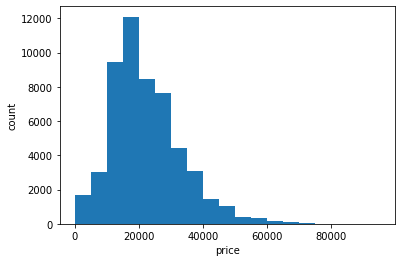

In [77]:
bin_edges = np.arange(0, train_data['price'].max()+5000, 5000)
plt.hist(x=train_data['price'], bins=bin_edges)
plt.ylabel('count')
plt.xlabel('price')

In [76]:
train_model_counts = train_data['model'].value_counts()
train_model_counts = train_model_counts[train_model_counts > 5]

train_data = train_data[train_data['model'].isin(train_model_counts.index)]

train_model_counts

chevrolet-silverado    2916
ford-f150              2912
ram-1500               2094
gmc-sierra             1398
jeep-cherokee          1167
                       ... 
gmc-3500                 17
mercedes-benz-s          12
mercedes-benz-e350        9
dodge-2500                9
gmc-2500                  7
Name: model, Length: 236, dtype: int64

In [78]:
y = train_data['model']
X = train_data.drop(columns='model')

In [79]:
# from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

X_resampled, y_resampled = SMOTEENN().fit_sample(X,y)

In [80]:
resampled_df = X_resampled.copy()

resampled_df['model'] = y_resampled

resampled_df

,price,odometer,transmission_automatic,transmission_manual,transmission_other,transmission_unspecified,paint_color_black,paint_color_blue,paint_color_brown,paint_color_custom,...,model_volkswagen-beetle,model_volkswagen-golf,model_volkswagen-gti,model_volkswagen-jetta,model_volkswagen-passat,model_volkswagen-tiguan,model_volvo-s60,model_volvo-xc60,model_volvo-xc90,model
0,15367.000000,74455.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,acura-ilx
1,12999.000000,31000.000000,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,acura-ilx
2,19598.000000,10258.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,acura-ilx
3,18577.000000,43567.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,acura-ilx
4,16790.000000,42242.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,acura-ilx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214990,33072.615421,57744.024724,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,volvo-xc90
214991,52860.401030,11849.731138,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,volvo-xc90
214992,32771.007794,58726.390915,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,volvo-xc90
214993,32629.221371,58984.607795,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,volvo-xc90


Text(0.5, 0, 'price')

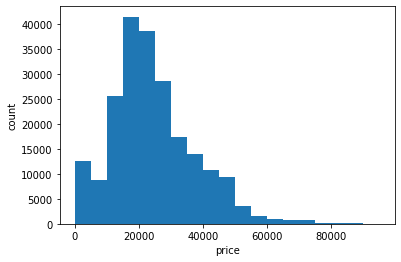

In [81]:
plt.hist(x=resampled_df['price'], bins=bin_edges)
plt.ylabel('count')
plt.xlabel('price')

In [82]:
resampled_df.to_csv(os.path.join(data_dir, 'vechiles_train_resampled.csv'), index=False)

In [83]:
train_data = resampled_df.drop(columns='model')
valid_data = valid_data.drop(columns='model')
test_data = test_data.drop(columns='model')

In [84]:
train_data = train_data.sample(frac=1)

train_data

,price,odometer,transmission_automatic,transmission_manual,transmission_other,transmission_unspecified,paint_color_black,paint_color_blue,paint_color_brown,paint_color_custom,...,model_volkswagen-atlas,model_volkswagen-beetle,model_volkswagen-golf,model_volkswagen-gti,model_volkswagen-jetta,model_volkswagen-passat,model_volkswagen-tiguan,model_volvo-s60,model_volvo-xc60,model_volvo-xc90
103740,29936.755458,3801.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91744,41900.000000,64000.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
194261,10499.000000,100000.000000,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1026,31999.000000,28754.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34680,35772.380043,41181.294817,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112303,24234.430093,35834.629851,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
179229,32989.000000,34486.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
128381,1.000000,42422.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75510,59999.000000,25815.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
from sklearn.model_selection import train_test_split

y_test = pd.DataFrame(test_data['price'])
X_test = test_data.drop(columns='price')

y_train = pd.DataFrame(train_data['price'])
X_train = train_data.drop(columns='price')

y_valid = pd.DataFrame(valid_data['price'])
X_valid = valid_data.drop(columns='price')

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(214995, 295)
(26719, 295)
(26719, 295)


In [87]:
X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)
y_test.to_csv(os.path.join(data_dir, 'test_y.csv'), header=False, index=False)

pd.concat([y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)
pd.concat([y_valid, X_valid], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)